## Takwa Kadri

# Stock Market Prediction using Numerical and Textual Analysis

## Downloading Datasets

In [1]:

import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [72]:
price = pd.read_csv('AAPL (1).csv')
headlines = pd.read_csv('india-news-headlines (3).csv')

In [6]:
# displaying stock price dataset
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-20,115.750000,118.392502,115.732498,118.275002,117.519142,126907200
1,2020-08-21,119.262497,124.867500,119.250000,124.370003,123.575188,338054800
2,2020-08-24,128.697495,128.785004,123.937500,125.857498,125.053177,345937600
3,2020-08-25,124.697502,125.180000,123.052498,124.824997,124.027283,211495600
4,2020-08-26,126.180000,126.992500,125.082497,126.522499,125.713928,163022400


In [7]:


headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


# Feature Engineering

In [8]:
# displaying number of records in both stock_price and stock_headlines datasets
len(price), len(headlines)

(252, 3424067)

In [9]:
# checking for null values in both the datasets
price.isna().any(), headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [10]:
# dropping duplicates
headlines = headlines.drop_duplicates()



In [11]:
# coverting the datatype of column 'Date' from type string to type 'datetime'
headlines['publish_date'] =headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()


In [12]:

# filtering the important columns required
headlines= headlines.filter(['publish_date', 'headline_text'])


In [13]:

# grouping the news headlines according to 'Date'
headlines = headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()



In [14]:
# setting column 'Date' as the index column
headlines.set_index('publish_date', inplace= True)


In [16]:

# sorting the data according to the index i.e 'Date'
headlines = headlines.sort_index(ascending=True, axis=0)
headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [17]:
# dropping duplicates
price = price.drop_duplicates()


In [18]:

# coverting the datatype of column 'Date' from type object to type 'datetime'
price['Date'] = pd.to_datetime(price['Date']).dt.normalize()


In [19]:

# filtering the important columns required
price= price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])


In [20]:

# setting column 'Date' as the index column
price.set_index('Date', inplace= True)


In [21]:

# sorting the data according to the index i.e 'Date'
price = price.sort_index(ascending=True, axis=0)
price

,Close,Open,High,Low,Volume
Date,,,,,
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600
2020-08-26,126.522499,126.180000,126.992500,125.082497,163022400
...,...,...,...,...,...
2021-08-13,149.100006,148.970001,149.440002,148.270004,59318800
2021-08-16,151.119995,148.539993,151.190002,146.470001,103296000
2021-08-17,150.190002,150.229996,151.679993,149.089996,92229700


In [22]:

# concatenating the datasets stock_price and stock_headlines
stock = pd.concat([price, headlines], axis=1)


In [23]:

# dropping the null values if any
stock.dropna(axis=0, inplace=True)



In [24]:
# displaying the combined stock_data
stock

,Close,Open,High,Low,Volume,headline_text
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused..."
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...
2020-08-26,126.522499,126.180000,126.992500,125.082497,163022400.0,Siddhant Chaturvedi remembers his Ganesh Utsav...
...,...,...,...,...,...,...
2020-12-24,131.970001,131.320007,133.460007,131.100006,54930100.0,How to set the mood for sex during cold winter...
2020-12-28,136.690002,133.990005,137.339996,133.509995,124486200.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,134.869995,138.050003,138.789993,134.339996,121047300.0,Man recovers charred remains of 'thief' from h...
2020-12-30,133.720001,135.580002,135.990005,133.399994,96452100.0,Numerology Readings 30 December 2020: Predicti...


In [25]:
# adding empty sentiment columns to stock_data for later calculation
stock['compound'] = ''
stock['negative'] = ''
stock['neutral'] = ''
stock['positive'] = ''
stock.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused...",,,,
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...,,,,
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...,,,,
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...,,,,
2020-08-26,126.522499,126.180000,126.992500,125.082497,163022400.0,Siddhant Chaturvedi remembers his Ganesh Utsav...,,,,


In [26]:

# importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata



In [27]:
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()




In [28]:
# calculating sentiment scores
stock['compound'] =stock['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock['negative'] = stock['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock['neutral'] = stock['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock['positive'] = stock['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# displaying the stock data
stock.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-08-20,118.275002,115.750000,118.392502,115.732498,126907200.0,"Stay away from water bodies: DDMA,Main accused...",-0.9995,0.103,0.829,0.068
2020-08-21,124.370003,119.262497,124.867500,119.250000,338054800.0,Nothing is impossible in life because impossib...,-0.9995,0.120,0.797,0.083
2020-08-24,125.857498,128.697495,128.785004,123.937500,345937600.0,Sonali Bendre looks like true 'Mumbai chi mulg...,-0.9996,0.127,0.786,0.087
2020-08-25,124.824997,124.697502,125.180000,123.052498,211495600.0,Every thought if cats love you less than dogs ...,-0.9997,0.110,0.828,0.062
2020-08-26,126.522499,126.180000,126.992500,125.082497,163022400.0,Siddhant Chaturvedi remembers his Ganesh Utsav...,-0.9999,0.169,0.762,0.068


In [29]:
# dropping the 'headline_text' which is unwanted now
stock.drop(['headline_text'], inplace=True, axis=1)



In [30]:
# rearranging the columns of the whole stock_data
stock = stock[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-08-20,118.275002,-0.9995,0.103,0.829,0.068,115.750000,118.392502,115.732498,126907200.0
2020-08-21,124.370003,-0.9995,0.120,0.797,0.083,119.262497,124.867500,119.250000,338054800.0
2020-08-24,125.857498,-0.9996,0.127,0.786,0.087,128.697495,128.785004,123.937500,345937600.0
2020-08-25,124.824997,-0.9997,0.110,0.828,0.062,124.697502,125.180000,123.052498,211495600.0
2020-08-26,126.522499,-0.9999,0.169,0.762,0.068,126.180000,126.992500,125.082497,163022400.0


In [31]:
# writing the prepared stock_data to disk
stock.to_csv('stock_data.csv')

In [32]:
# re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv('stock_data.csv', index_col = False)


In [33]:

# renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)



In [34]:
# setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-08-20,118.275002,-0.9995,0.103,0.829,0.068,115.750000,118.392502,115.732498,126907200.0
2020-08-21,124.370003,-0.9995,0.120,0.797,0.083,119.262497,124.867500,119.250000,338054800.0
2020-08-24,125.857498,-0.9996,0.127,0.786,0.087,128.697495,128.785004,123.937500,345937600.0
2020-08-25,124.824997,-0.9997,0.110,0.828,0.062,124.697502,125.180000,123.052498,211495600.0
2020-08-26,126.522499,-0.9999,0.169,0.762,0.068,126.180000,126.992500,125.082497,163022400.0


In [35]:

# displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(93, 9)

In [36]:

# checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [37]:
# displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,9.300000e+01
mean,119.509005,-0.978180,0.129215,0.792409,0.078301,119.704651,121.325860,117.720591,1.395643e+08
std,6.812714,0.207085,0.016907,0.023082,0.011229,7.012889,6.773840,6.840130,6.060611e+07
min,106.839996,-0.999900,0.082000,0.742000,0.047000,104.540001,110.190002,103.099998,4.669130e+07
25%,115.050003,-0.999900,0.120000,0.779000,0.073000,115.050003,116.550003,112.879997,9.645210e+07
50%,118.639999,-0.999800,0.129000,0.789000,0.078000,118.610001,119.669998,116.449997,1.244862e+08
75%,123.750000,-0.999600,0.140000,0.805000,0.084000,124.339996,125.180000,121.540001,1.677433e+08
max,136.690002,0.997400,0.169000,0.854000,0.127000,138.050003,138.789993,134.339996,3.459376e+08


In [38]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 2020-08-20 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     93 non-null     float64
 1   compound  93 non-null     float64
 2   negative  93 non-null     float64
 3   neutral   93 non-null     float64
 4   positive  93 non-null     float64
 5   Open      93 non-null     float64
 6   High      93 non-null     float64
 7   Low       93 non-null     float64
 8   Volume    93 non-null     float64
dtypes: float64(9)
memory usage: 7.3+ KB


Text(0, 0.5, 'Close Price ($)')

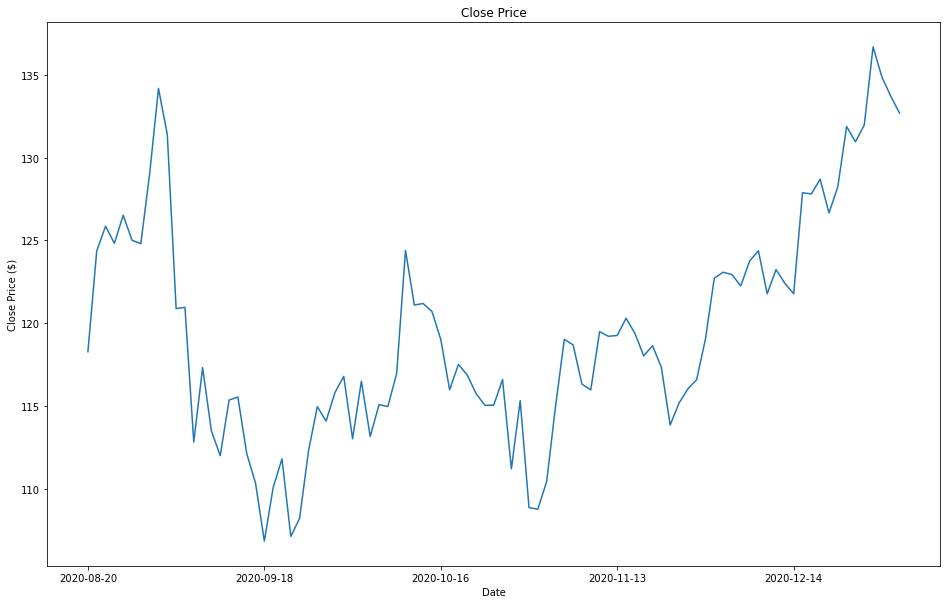

In [39]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [40]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-08-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-28,124.238215,-0.999614,0.124857,0.797286,0.077857,123.963213,125.449286,122.209284,2.183714e+08
2020-08-31,125.776071,-0.999671,0.132000,0.787571,0.080571,125.653214,127.250357,123.676070,2.324851e+08
2020-09-01,127.177498,-0.999714,0.134143,0.785571,0.080429,127.581428,128.669286,125.287499,2.058984e+08


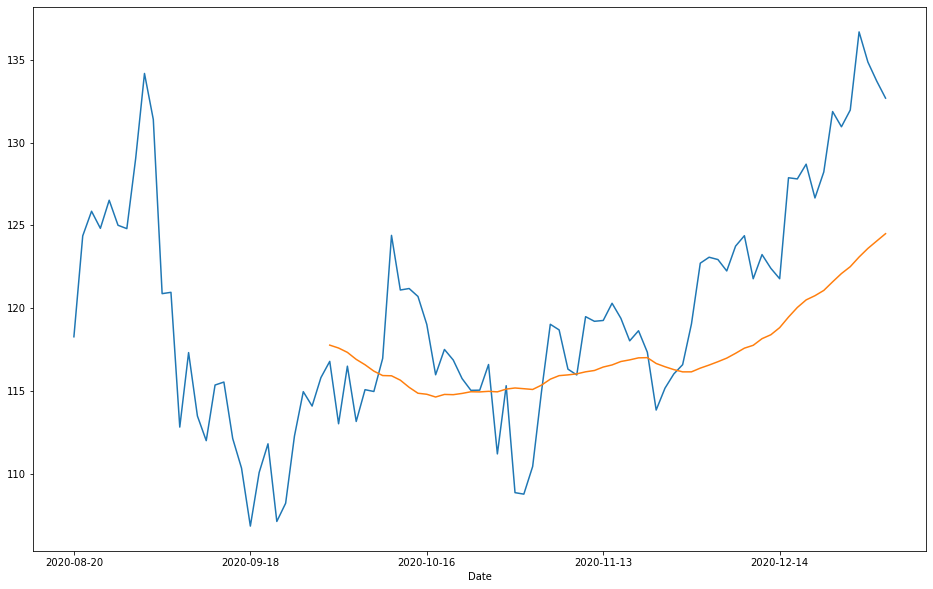

In [41]:

# setting figure size
plt.figure(figsize=(16,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [42]:
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-08-20,118.275002,-0.9995,0.103,0.829,0.068,115.750000,118.392502,115.732498,126907200.0
2020-08-21,124.370003,-0.9995,0.120,0.797,0.083,119.262497,124.867500,119.250000,338054800.0
2020-08-24,125.857498,-0.9996,0.127,0.786,0.087,128.697495,128.785004,123.937500,345937600.0
2020-08-25,124.824997,-0.9997,0.110,0.828,0.062,124.697502,125.180000,123.052498,211495600.0
2020-08-26,126.522499,-0.9999,0.169,0.762,0.068,126.180000,126.992500,125.082497,163022400.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,131.970001,-0.9971,0.082,0.854,0.064,131.320007,133.460007,131.100006,54930100.0
2020-12-28,136.690002,-0.9997,0.126,0.789,0.085,133.990005,137.339996,133.509995,124486200.0
2020-12-29,134.869995,-0.9998,0.136,0.774,0.090,138.050003,138.789993,134.339996,121047300.0


# Data Preparation for Modelling

In [43]:
# calculating data_to_use
data_percent = 1.0
use_data = int(data_percent*(len(stock_data)-1))



In [44]:
# using 70% of data for training
train_end = int(use_data*0.7)
total_data = len(stock_data)
start = total_data - use_data

# printing number of records in the training and test datasets
print("Number of records in Training :", train_end)
print("Number of records in Test :", total_data - train_end)

Number of records in Training : 64
Number of records in Test : 29


In [45]:
# predicting one step ahead
steps_to_predict = 1

# capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


Date
2020-08-21    124.370003
2020-08-24    125.857498
2020-08-25    124.824997
2020-08-26    126.522499
2020-08-27    125.010002
                 ...    
2020-12-24    131.970001
2020-12-28    136.690002
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, Length: 92, dtype: float64

In [46]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2020-08-21,124.370003,125.857498,-0.9995,-0.9996,338054800.0,119.262497,124.867500,119.250000
2020-08-24,125.857498,124.824997,-0.9996,-0.9997,345937600.0,128.697495,128.785004,123.937500
2020-08-25,124.824997,126.522499,-0.9997,-0.9999,211495600.0,124.697502,125.180000,123.052498
2020-08-26,126.522499,125.010002,-0.9999,-0.9996,163022400.0,126.180000,126.992500,125.082497
2020-08-27,125.010002,124.807503,-0.9996,-0.9995,155552400.0,127.142502,127.485001,123.832497
2020-08-28,124.807503,129.039993,-0.9995,-0.9999,187630000.0,126.012497,126.442497,124.577499
2020-08-31,129.039993,134.179993,-0.9999,-0.9998,225702700.0,127.580002,131.000000,126.000000
2020-09-01,134.179993,131.399994,-0.9998,-0.9995,151948100.0,132.759995,134.800003,130.529999
2020-09-02,131.399994,120.879997,-0.9995,-0.9999,200119000.0,137.589996,137.979996,127.000000


In [47]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2020-08-21    125.857498
2020-08-24    124.824997
2020-08-25    126.522499
2020-08-26    125.010002
2020-08-27    124.807503
                 ...    
2020-12-23    131.970001
2020-12-24    136.690002
2020-12-28    134.869995
2020-12-29    133.720001
2020-12-30    132.690002
Name: close_price_shifted, Length: 91, dtype: float64

In [48]:

# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2020-08-21,124.370003,-0.9995,-0.9996,338054800.0,119.262497,124.867500,119.250000
2020-08-24,125.857498,-0.9996,-0.9997,345937600.0,128.697495,128.785004,123.937500
2020-08-25,124.824997,-0.9997,-0.9999,211495600.0,124.697502,125.180000,123.052498
2020-08-26,126.522499,-0.9999,-0.9996,163022400.0,126.180000,126.992500,125.082497
2020-08-27,125.010002,-0.9996,-0.9995,155552400.0,127.142502,127.485001,123.832497
...,...,...,...,...,...,...,...
2020-12-23,130.960007,-0.9996,-0.9971,88223700.0,132.160004,132.429993,130.779999
2020-12-24,131.970001,-0.9971,-0.9997,54930100.0,131.320007,133.460007,131.100006
2020-12-28,136.690002,-0.9997,-0.9998,124486200.0,133.990005,137.339996,133.509995


In [49]:

# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[ 1.74539596e-01, -9.99599459e-01, -9.99699594e-01,
          9.47315639e-01, -1.21307364e-01,  2.63987845e-02,
          3.39310521e-02],
        [ 2.74204233e-01, -9.99699594e-01, -9.99799730e-01,
          1.00000000e+00,  4.41807971e-01,  3.00350199e-01,
          3.34027102e-01],
        [ 2.05024950e-01, -9.99799730e-01, -1.00000000e+00,
          1.01462574e-01,  2.03073697e-01,  4.82519383e-02,
          2.77368840e-01],
        [ 3.18760405e-01, -1.00000000e+00, -9.99699594e-01,
         -2.22506009e-01,  2.91554623e-01,  1.75000230e-01,
          4.07330372e-01],
        [ 2.17420593e-01, -9.99699594e-01, -9.99599459e-01,
         -2.72431439e-01,  3.49000278e-01,  2.09440870e-01,
          3.27304758e-01],
        [ 2.03852823e-01, -9.99599459e-01, -1.00000000e+00,
         -5.80421546e-02,  2.81557429e-01,  1.36538470e-01,
          3.75000152e-01],
        [ 4.87436686e-01, -1.00000000e+00, -9.99899865e-01,
          1.96415127e-01,  3.75111885e-01,  4.55245073e-01

In [50]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (64, 7) and y: (64, 1)
Number of rows and columns in the Test set X: (26, 7) and y: (26, 1)


In [51]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (64, 7, 1)
Shape of Test set X: (26, 7, 1)


# Modelling

In [52]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [53]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
7/7 [==============================] - 13s 332ms/step - loss: 0.2125 - val_loss: 0.0254
Epoch 2/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1267 - val_loss: 0.0492
Epoch 3/10
7/7 [==============================] - 0s 17ms/step - loss: 0.1134 - val_loss: 0.0146
Epoch 4/10
7/7 [==============================] - 0s 17ms/step - loss: 0.0971 - val_loss: 0.0655
Epoch 5/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0974 - val_loss: 0.0241
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0834 - val_loss: 0.0375
Epoch 7/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0710 - val_loss: 0.0389
Epoch 8/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0799 - val_loss: 0.0638
Epoch 9/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0714 - val_loss: 0.0634
Epoch 10/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0726 - val_loss: 0.0472


In [54]:

# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')


# Prediction

In [55]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[115.0993  ],
       [114.667145],
       [114.58888 ],
       [114.40375 ],
       [118.675545]], dtype=float32)

# Evaluation

In [56]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

26/26 [==============================] - 0s 5ms/step - loss: 0.1262
Train Loss = 0.0598
Test Loss = 0.1262


In [57]:

# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 120.8698


In [58]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 120.8698


In [59]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

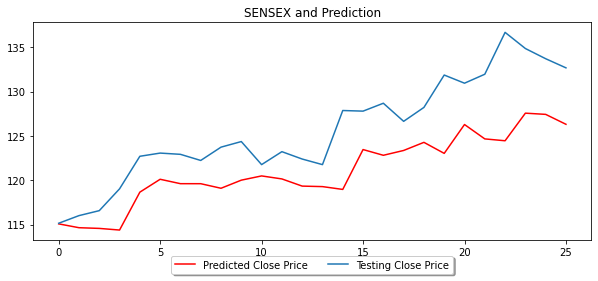

In [67]:

# plotting the prediction and original dataset on the same plot
    
plt.figure(figsize=(10,4))
plt.plot(predictions, label="Predicted Close Price", color='r')
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.title('SENSEX and Prediction')
plt.show()